In [1]:
import numpy as np
import tensorflow as tf
#
FOLDERNAME = '/home/bdelorme/RainfallNowcasting/Radar/scripts'
import sys
sys.path.append(FOLDERNAME)
#
from data_lab import *
from utils import *
from models import *
from metrics import *
from plot_tools import *

In [10]:
#########################################################################################
#################################### GLOBAL FEATURES ####################################
#########################################################################################
data_dir = '/home/bdelorme/RainfallNowcasting/Radar/MeteoNet/'
zone = "NW"                           # NW, SE
years = [2017]                        # 2016, 2017, 2018
months = [8]                          # 1...12
parts_month = [3]                     # 1,2,3 (each month is divided in 3 parts)
new_size = [64,64]                    # None = keep initial size
input_timeframes = 10                 # how many timeframes for input
output_timeframes = 5                 # how many timeframes for output
overlapping_data = 0                  # data overlap in time (= 1) or not (= 0)
archi = 'ddnet'                       # ddnet or convdlrm
fraction_test = 0.1                   # fraction of test data
rainfall_threshold_value = 80         # Value above which values are considered to be one
#########################################################################################
################################## ADDITIONAL FEATURES ##################################
#########################################################################################
features_bool = {'reflectivity': 1, 
                 'rainfall quality': 1,
                 'land sea': 1, 
                 'elevation': 1}
features_max_threshold = {'reflectivity': 60, 
                          'rainfall quality': 100, 
                          'land sea': 1, 
                          'elevation': 629}
features_min_threshold = {'reflectivity': 0, 
                          'rainfall quality': 0, 
                          'land sea': 0, 
                          'elevation': 0}
#
wf_model = 'arpege' # None for no model, otherwise arpege
weather_model_bool = {'temperature': 1, 
                      'dew point temperature' : 1,
                      'humidity': 1, 
                      'wind speed': 1, 
                      'wind directions': 1,
                      'wind components': 1, 
                      'pressure': 1,
                      'precipitation': 1}
weather_model_max_threshold = {'temperature': 313, 
                               'dew point temperature' : 313,
                               'humidity': 100, 
                               'wind speed': 35, 
                               'wind directions': 360,
                               'wind components': 35, 
                               'pressure': 105000,
                               'precipitation': rainfall_threshold_value}
weather_model_min_threshold = {'temperature': 263, 
                               'dew point temperature' : 263,
                               'humidity': 0, 
                               'wind speed': 0, 
                               'wind directions': 0,
                               'wind components': -35, 
                               'pressure': 96000,
                               'precipitation': 0}
#########################################################################################
#########################################################################################
#########################################################################################

In [11]:
# Getting data and features 
X, y, features_list = get_data_and_features(data_dir, zone, years, months, parts_month, 
                                            new_size, input_timeframes, output_timeframes,
                                            fraction_test, rainfall_threshold_value, 
                                            features_bool, weather_model_bool, wf_model,
                                            weather_model_max_threshold, weather_model_min_threshold,
                                            features_max_threshold, features_min_threshold,
                                            overlapping_data)
print(X.shape)
print(y.shape)
print(features_list)

Year: 2017 Month: 8 Part of the month: 3, Done !
Got rainfall
Year: 2017 Month: 8 Part of the month: 3, Done !
Got reflectivity
Year: 2017 Month: 8 Part of the month: 3, Done !
Got rainfall quality


Ignoring index file '/home/bdelorme/RainfallNowcasting/Radar/MeteoNet/models_2D_NW/arpege/2m/arpege_2m_NW_20170821000000.grib.4cc40.idx' incompatible with GRIB file


Got land sea
Got elevation


Ignoring index file '/home/bdelorme/RainfallNowcasting/Radar/MeteoNet/models_2D_NW/arpege/2m/arpege_2m_NW_20170822000000.grib.4cc40.idx' incompatible with GRIB file


2017-08-21 00:00:00


Ignoring index file '/home/bdelorme/RainfallNowcasting/Radar/MeteoNet/models_2D_NW/arpege/2m/arpege_2m_NW_20170823000000.grib.4cc40.idx' incompatible with GRIB file


2017-08-22 00:00:00


Ignoring index file '/home/bdelorme/RainfallNowcasting/Radar/MeteoNet/models_2D_NW/arpege/2m/arpege_2m_NW_20170824000000.grib.4cc40.idx' incompatible with GRIB file


2017-08-23 00:00:00


Ignoring index file '/home/bdelorme/RainfallNowcasting/Radar/MeteoNet/models_2D_NW/arpege/2m/arpege_2m_NW_20170825000000.grib.4cc40.idx' incompatible with GRIB file


2017-08-24 00:00:00


Ignoring index file '/home/bdelorme/RainfallNowcasting/Radar/MeteoNet/models_2D_NW/arpege/2m/arpege_2m_NW_20170825000000.grib.4cc40.idx' incompatible with GRIB file
Ignoring index file '/home/bdelorme/RainfallNowcasting/Radar/MeteoNet/models_2D_NW/arpege/2m/arpege_2m_NW_20170827000000.grib.4cc40.idx' incompatible with GRIB file


2017-08-25 00:00:00


Ignoring index file '/home/bdelorme/RainfallNowcasting/Radar/MeteoNet/models_2D_NW/arpege/2m/arpege_2m_NW_20170827000000.grib.4cc40.idx' incompatible with GRIB file


2017-08-26 00:00:00


Ignoring index file '/home/bdelorme/RainfallNowcasting/Radar/MeteoNet/models_2D_NW/arpege/2m/arpege_2m_NW_20170828000000.grib.4cc40.idx' incompatible with GRIB file


2017-08-27 00:00:00


Ignoring index file '/home/bdelorme/RainfallNowcasting/Radar/MeteoNet/models_2D_NW/arpege/2m/arpege_2m_NW_20170829000000.grib.4cc40.idx' incompatible with GRIB file


2017-08-28 00:00:00


Ignoring index file '/home/bdelorme/RainfallNowcasting/Radar/MeteoNet/models_2D_NW/arpege/2m/arpege_2m_NW_20170830000000.grib.4cc40.idx' incompatible with GRIB file


2017-08-29 00:00:00


Ignoring index file '/home/bdelorme/RainfallNowcasting/Radar/MeteoNet/models_2D_NW/arpege/2m/arpege_2m_NW_20170831000000.grib.4cc40.idx' incompatible with GRIB file


2017-08-30 00:00:00


Ignoring index file '/home/bdelorme/RainfallNowcasting/Radar/MeteoNet/models_2D_NW/arpege/10m/arpege_10m_NW_20170821000000.grib.4cc40.idx' incompatible with GRIB file


2017-08-31 00:00:00
2m


Ignoring index file '/home/bdelorme/RainfallNowcasting/Radar/MeteoNet/models_2D_NW/arpege/10m/arpege_10m_NW_20170822000000.grib.4cc40.idx' incompatible with GRIB file


2017-08-21 00:00:00


Ignoring index file '/home/bdelorme/RainfallNowcasting/Radar/MeteoNet/models_2D_NW/arpege/10m/arpege_10m_NW_20170823000000.grib.4cc40.idx' incompatible with GRIB file


2017-08-22 00:00:00


Ignoring index file '/home/bdelorme/RainfallNowcasting/Radar/MeteoNet/models_2D_NW/arpege/10m/arpege_10m_NW_20170824000000.grib.4cc40.idx' incompatible with GRIB file


2017-08-23 00:00:00


Ignoring index file '/home/bdelorme/RainfallNowcasting/Radar/MeteoNet/models_2D_NW/arpege/10m/arpege_10m_NW_20170825000000.grib.4cc40.idx' incompatible with GRIB file


2017-08-24 00:00:00


Ignoring index file '/home/bdelorme/RainfallNowcasting/Radar/MeteoNet/models_2D_NW/arpege/10m/arpege_10m_NW_20170825000000.grib.4cc40.idx' incompatible with GRIB file


2017-08-25 00:00:00


Ignoring index file '/home/bdelorme/RainfallNowcasting/Radar/MeteoNet/models_2D_NW/arpege/10m/arpege_10m_NW_20170827000000.grib.4cc40.idx' incompatible with GRIB file
Ignoring index file '/home/bdelorme/RainfallNowcasting/Radar/MeteoNet/models_2D_NW/arpege/10m/arpege_10m_NW_20170827000000.grib.4cc40.idx' incompatible with GRIB file


2017-08-26 00:00:00


Ignoring index file '/home/bdelorme/RainfallNowcasting/Radar/MeteoNet/models_2D_NW/arpege/10m/arpege_10m_NW_20170828000000.grib.4cc40.idx' incompatible with GRIB file


2017-08-27 00:00:00


Ignoring index file '/home/bdelorme/RainfallNowcasting/Radar/MeteoNet/models_2D_NW/arpege/10m/arpege_10m_NW_20170829000000.grib.4cc40.idx' incompatible with GRIB file


2017-08-28 00:00:00


Ignoring index file '/home/bdelorme/RainfallNowcasting/Radar/MeteoNet/models_2D_NW/arpege/10m/arpege_10m_NW_20170830000000.grib.4cc40.idx' incompatible with GRIB file


2017-08-29 00:00:00


Ignoring index file '/home/bdelorme/RainfallNowcasting/Radar/MeteoNet/models_2D_NW/arpege/10m/arpege_10m_NW_20170831000000.grib.4cc40.idx' incompatible with GRIB file


2017-08-30 00:00:00


Ignoring index file '/home/bdelorme/RainfallNowcasting/Radar/MeteoNet/models_2D_NW/arpege/P_sea_level/arpege_P_sea_level_NW_20170821000000.grib.4cc40.idx' incompatible with GRIB file


2017-08-31 00:00:00
10m


Ignoring index file '/home/bdelorme/RainfallNowcasting/Radar/MeteoNet/models_2D_NW/arpege/P_sea_level/arpege_P_sea_level_NW_20170822000000.grib.4cc40.idx' incompatible with GRIB file
Ignoring index file '/home/bdelorme/RainfallNowcasting/Radar/MeteoNet/models_2D_NW/arpege/P_sea_level/arpege_P_sea_level_NW_20170823000000.grib.4cc40.idx' incompatible with GRIB file


2017-08-21 00:00:00
2017-08-22 00:00:00


Ignoring index file '/home/bdelorme/RainfallNowcasting/Radar/MeteoNet/models_2D_NW/arpege/P_sea_level/arpege_P_sea_level_NW_20170824000000.grib.4cc40.idx' incompatible with GRIB file
Ignoring index file '/home/bdelorme/RainfallNowcasting/Radar/MeteoNet/models_2D_NW/arpege/P_sea_level/arpege_P_sea_level_NW_20170825000000.grib.4cc40.idx' incompatible with GRIB file


2017-08-23 00:00:00
2017-08-24 00:00:00


Ignoring index file '/home/bdelorme/RainfallNowcasting/Radar/MeteoNet/models_2D_NW/arpege/P_sea_level/arpege_P_sea_level_NW_20170825000000.grib.4cc40.idx' incompatible with GRIB file
Ignoring index file '/home/bdelorme/RainfallNowcasting/Radar/MeteoNet/models_2D_NW/arpege/P_sea_level/arpege_P_sea_level_NW_20170827000000.grib.4cc40.idx' incompatible with GRIB file


2017-08-25 00:00:00


Ignoring index file '/home/bdelorme/RainfallNowcasting/Radar/MeteoNet/models_2D_NW/arpege/P_sea_level/arpege_P_sea_level_NW_20170827000000.grib.4cc40.idx' incompatible with GRIB file
Ignoring index file '/home/bdelorme/RainfallNowcasting/Radar/MeteoNet/models_2D_NW/arpege/P_sea_level/arpege_P_sea_level_NW_20170828000000.grib.4cc40.idx' incompatible with GRIB file


2017-08-26 00:00:00
2017-08-27 00:00:00


Ignoring index file '/home/bdelorme/RainfallNowcasting/Radar/MeteoNet/models_2D_NW/arpege/P_sea_level/arpege_P_sea_level_NW_20170829000000.grib.4cc40.idx' incompatible with GRIB file
Ignoring index file '/home/bdelorme/RainfallNowcasting/Radar/MeteoNet/models_2D_NW/arpege/P_sea_level/arpege_P_sea_level_NW_20170830000000.grib.4cc40.idx' incompatible with GRIB file
Ignoring index file '/home/bdelorme/RainfallNowcasting/Radar/MeteoNet/models_2D_NW/arpege/P_sea_level/arpege_P_sea_level_NW_20170831000000.grib.4cc40.idx' incompatible with GRIB file


2017-08-28 00:00:00
2017-08-29 00:00:00
2017-08-30 00:00:00


Ignoring index file '/home/bdelorme/RainfallNowcasting/Radar/MeteoNet/models_2D_NW/arpege/PRECIP/arpege_PRECIP_NW_20170821000000.grib.4cc40.idx' incompatible with GRIB file
Ignoring index file '/home/bdelorme/RainfallNowcasting/Radar/MeteoNet/models_2D_NW/arpege/PRECIP/arpege_PRECIP_NW_20170822000000.grib.4cc40.idx' incompatible with GRIB file


2017-08-31 00:00:00
P_sea_level
2017-08-21 00:00:00


Ignoring index file '/home/bdelorme/RainfallNowcasting/Radar/MeteoNet/models_2D_NW/arpege/PRECIP/arpege_PRECIP_NW_20170823000000.grib.4cc40.idx' incompatible with GRIB file
Ignoring index file '/home/bdelorme/RainfallNowcasting/Radar/MeteoNet/models_2D_NW/arpege/PRECIP/arpege_PRECIP_NW_20170824000000.grib.4cc40.idx' incompatible with GRIB file


2017-08-22 00:00:00
2017-08-23 00:00:00
2017-08-24 00:00:00


Ignoring index file '/home/bdelorme/RainfallNowcasting/Radar/MeteoNet/models_2D_NW/arpege/PRECIP/arpege_PRECIP_NW_20170825000000.grib.4cc40.idx' incompatible with GRIB file
Ignoring index file '/home/bdelorme/RainfallNowcasting/Radar/MeteoNet/models_2D_NW/arpege/PRECIP/arpege_PRECIP_NW_20170825000000.grib.4cc40.idx' incompatible with GRIB file
Ignoring index file '/home/bdelorme/RainfallNowcasting/Radar/MeteoNet/models_2D_NW/arpege/PRECIP/arpege_PRECIP_NW_20170827000000.grib.4cc40.idx' incompatible with GRIB file


2017-08-25 00:00:00


Ignoring index file '/home/bdelorme/RainfallNowcasting/Radar/MeteoNet/models_2D_NW/arpege/PRECIP/arpege_PRECIP_NW_20170827000000.grib.4cc40.idx' incompatible with GRIB file
Ignoring index file '/home/bdelorme/RainfallNowcasting/Radar/MeteoNet/models_2D_NW/arpege/PRECIP/arpege_PRECIP_NW_20170828000000.grib.4cc40.idx' incompatible with GRIB file


2017-08-26 00:00:00
2017-08-27 00:00:00


Ignoring index file '/home/bdelorme/RainfallNowcasting/Radar/MeteoNet/models_2D_NW/arpege/PRECIP/arpege_PRECIP_NW_20170829000000.grib.4cc40.idx' incompatible with GRIB file
Ignoring index file '/home/bdelorme/RainfallNowcasting/Radar/MeteoNet/models_2D_NW/arpege/PRECIP/arpege_PRECIP_NW_20170830000000.grib.4cc40.idx' incompatible with GRIB file


2017-08-28 00:00:00
2017-08-29 00:00:00


Ignoring index file '/home/bdelorme/RainfallNowcasting/Radar/MeteoNet/models_2D_NW/arpege/PRECIP/arpege_PRECIP_NW_20170831000000.grib.4cc40.idx' incompatible with GRIB file


2017-08-30 00:00:00
2017-08-31 00:00:00
PRECIP
Got model data
(211, 10, 64, 64, 14)
(211, 5, 64, 64, 1)
['reflectivity', 'quality', 'land sea mask', 'elevation', 'temperature', 'dew point temperature', 'humidity', 'wind speed', 'wind directions', 'pressure', 'precipitation', 'wind components']


In [12]:
# Get train-test
X, y, X_test, y_test = split_train_test(fraction_test, X, y)
print(X.shape)
print(y.shape)
print(X_test.shape)
print(y_test.shape)
if archi=='ddnet':
    X_content = get_content_data(X)
    X_content_test = get_content_data(X_test)
    print(X_content.shape)
    print(X_content_test.shape)
N, T, H, W, C = X.shape

(190, 10, 64, 64, 14)
(190, 5, 64, 64, 1)
(21, 10, 64, 64, 14)
(21, 5, 64, 64, 1)
(190, 64, 64, 14)
(21, 64, 64, 14)


In [13]:
#
# Archi Parameters
#
loss = 'logcosh'
optimizer = tf.keras.optimizers.Adam(lr=1e-4)
nk = 128
ks = 5
lks = 3
if archi=='convdlrm':
    activ = 'selu'
    init = 'lecun_normal'
    model = convdlrm_init(H, W, C, output_timeframes, nk, ks, lks, activ, init)
elif archi=='ddnet':
    activ = 'relu'
    init = 'he_normal'
    model = ddnet_init(H, W, C, output_timeframes, nk, ks, lks, activ, init)
#
bs = 2
ep = 2

In [14]:
# Build optimizer
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['acc', ssim, psnr, cor,
                       tf.keras.metrics.Precision(name='prec'),
                       tf.keras.metrics.Recall(name='recall')])

if archi=='convdlrm':
  # Fit the model
  history = model.fit(X, y, 
                      batch_size=bs, 
                      epochs=ep,
                      validation_split=0.1)
  # Get results on test set
  results = model.evaluate(X_test, y_test, batch_size=bs, return_dict=True)
elif archi=='ddnet':
  # Fit the model
  history = model.fit([X, X_content], y, 
                      batch_size=bs, 
                      epochs=ep,
                      validation_split=0.1)
  # Get results on test set
  results = model.evaluate([X_test, X_content_test], y_test, batch_size=bs, return_dict=True)

Epoch 1/2
86/86 [==============================] - 164s 2s/step - loss: 0.0368 - acc: 0.8839 - ssim: 0.8151 - psnr: 10.6703 - cor: 0.0779 - prec: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0360 - val_acc: 0.9018 - val_ssim: 0.8594 - val_psnr: 10.8080 - val_cor: 0.1075 - val_prec: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/2
11/11 [==============================] - 6s 571ms/step - loss: 0.0383 - acc: 0.8581 - ssim: 0.7778 - psnr: 10.4621 - cor: 0.0914 - prec: 0.0000e+00 - recall: 0.0000e+00


/home/bdelorme/RainfallNowcasting/Radar/results/ already exists


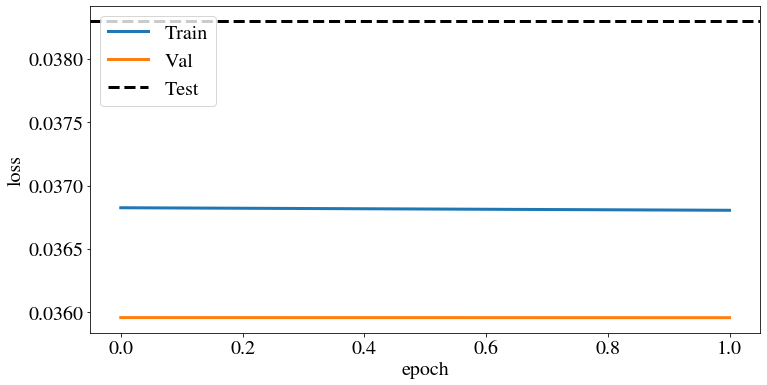

<Figure size 432x288 with 0 Axes>

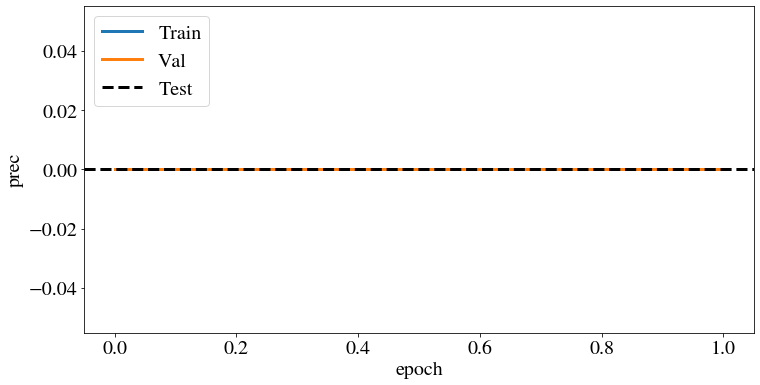

<Figure size 432x288 with 0 Axes>

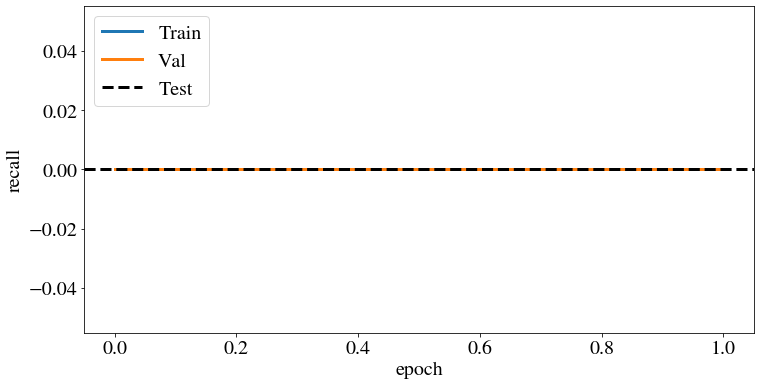

<Figure size 432x288 with 0 Axes>

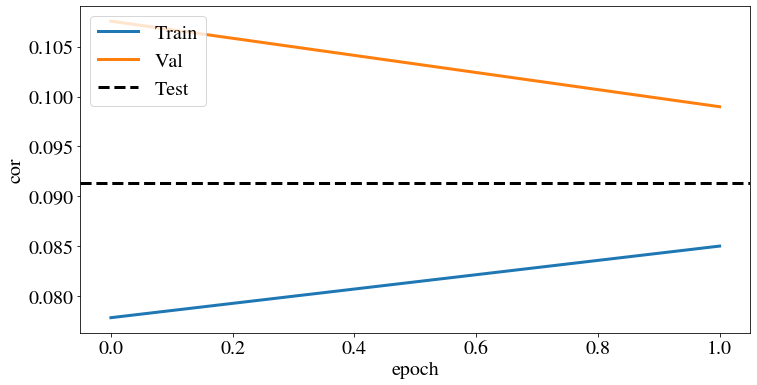

<Figure size 432x288 with 0 Axes>

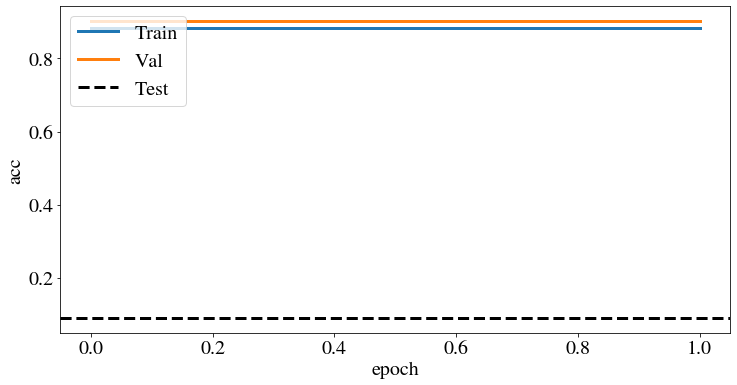

<Figure size 432x288 with 0 Axes>

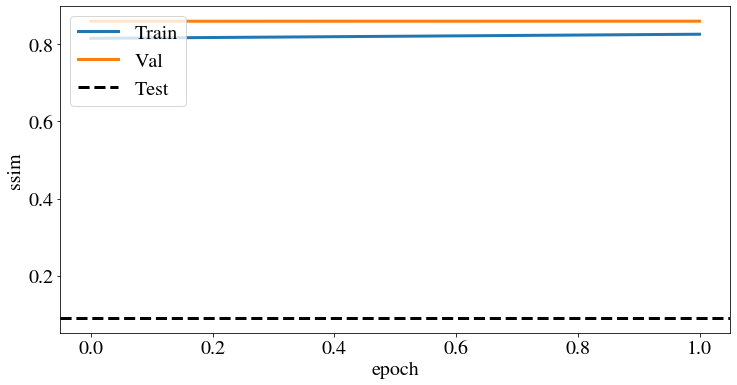

<Figure size 432x288 with 0 Axes>

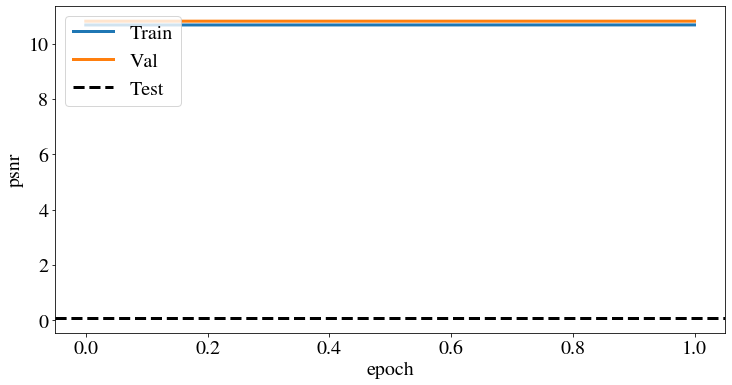

<Figure size 432x288 with 0 Axes>

In [15]:
# Plot of loss, accuracy, cor, prec and recall
foldername = "/home/bdelorme/RainfallNowcasting/Radar/results/"
plot_history(history, results, save=True, foldername=foldername)

/home/bdelorme/RainfallNowcasting/Radar/results/ already exists


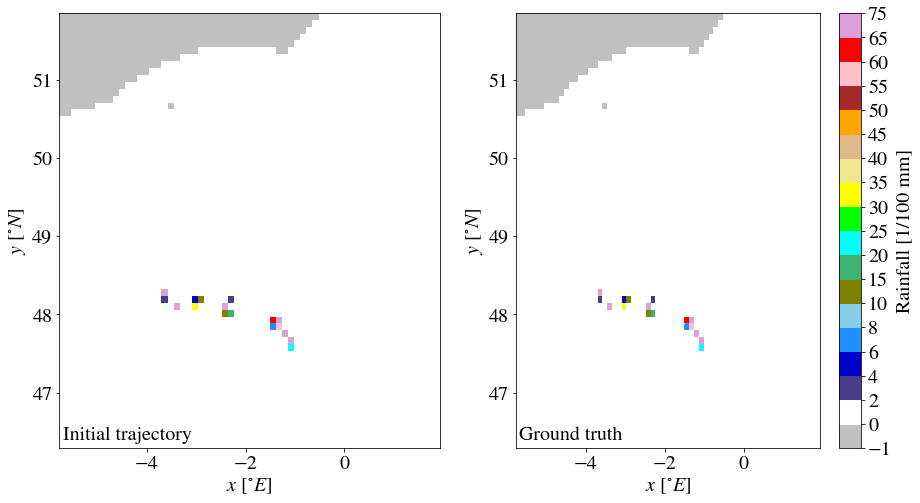

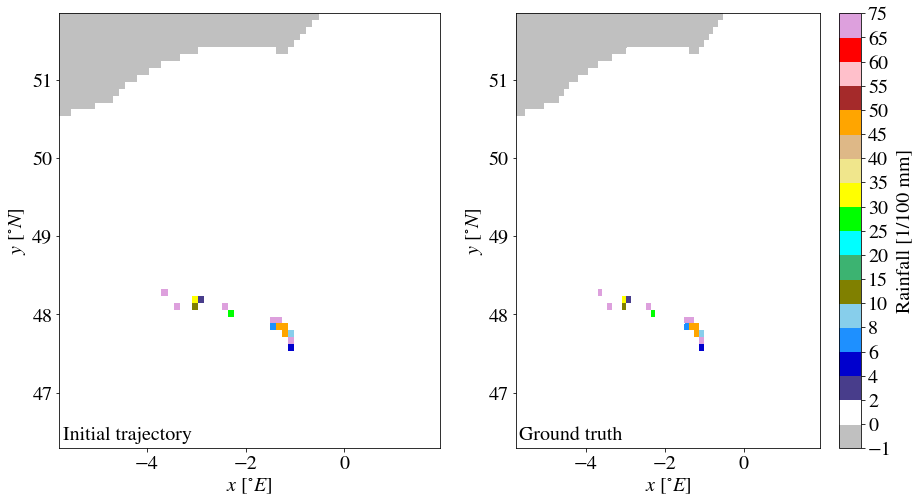

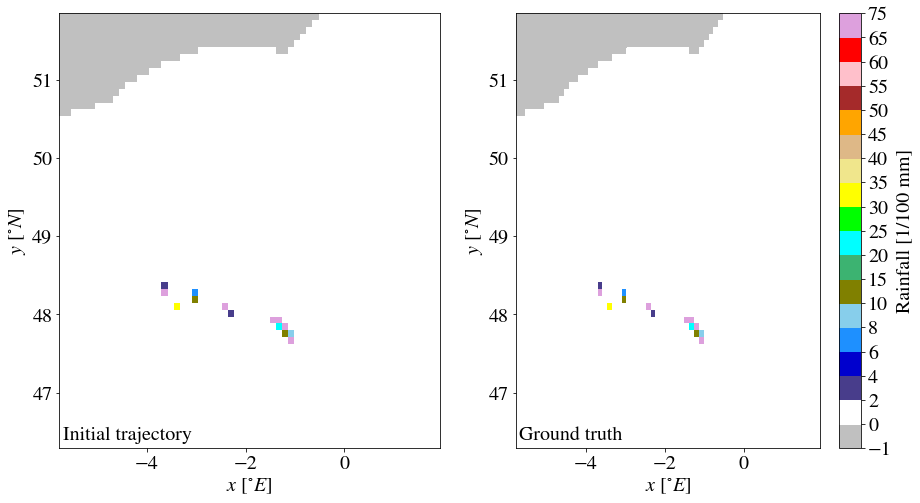

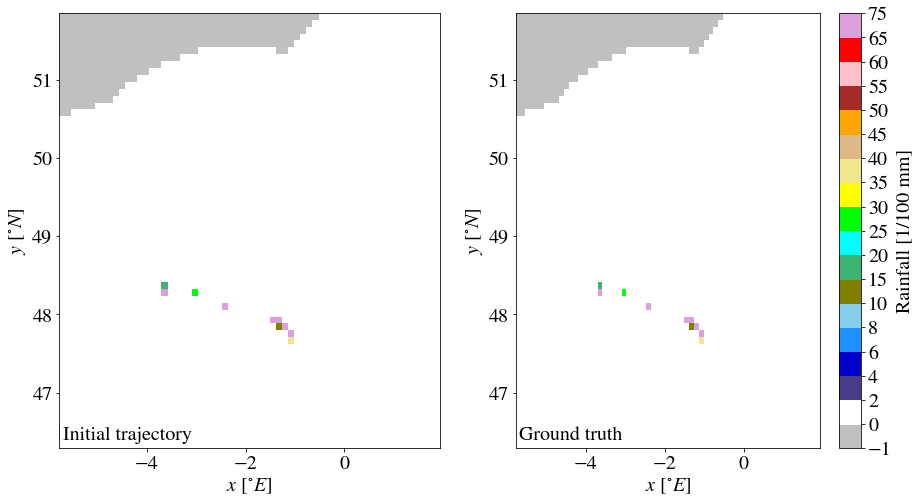

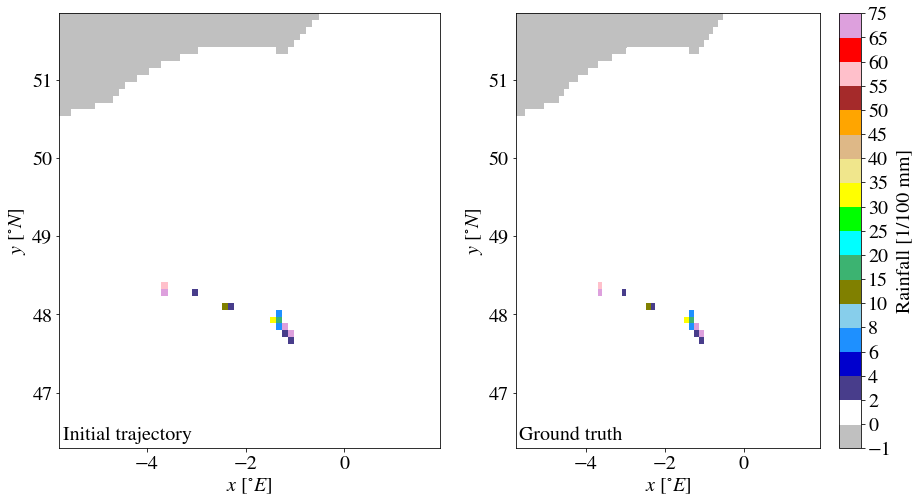

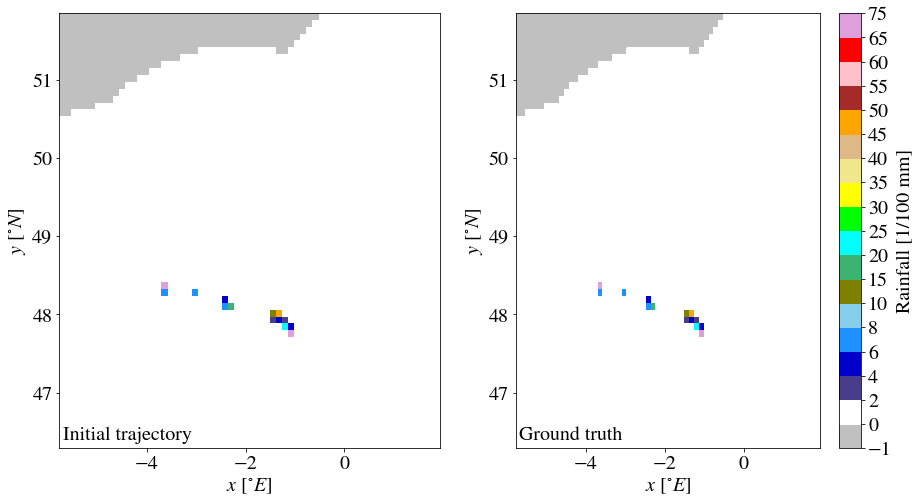

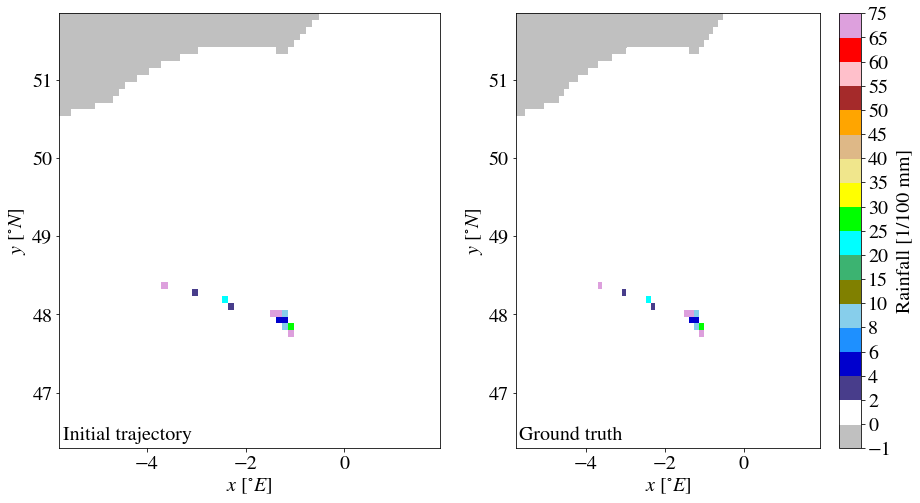

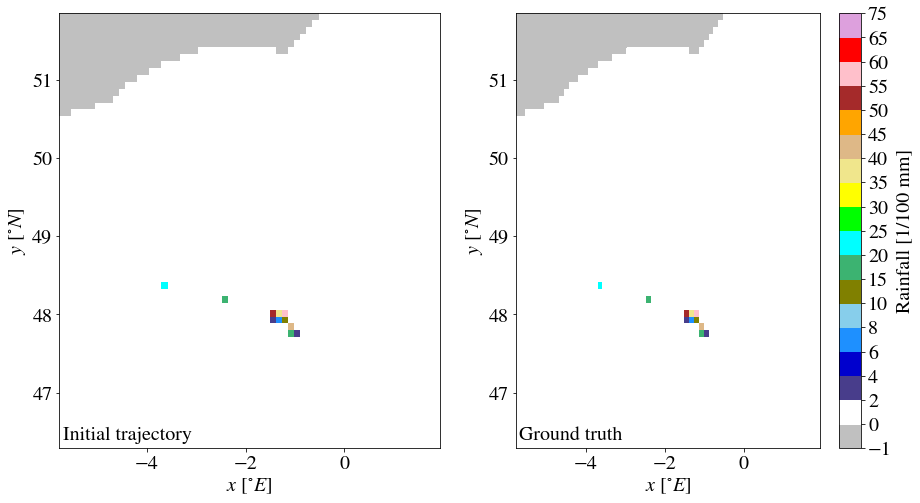

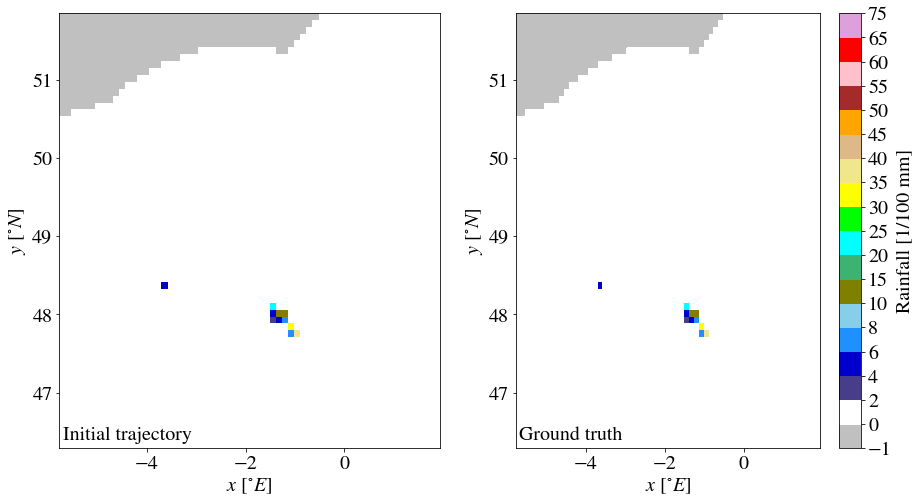

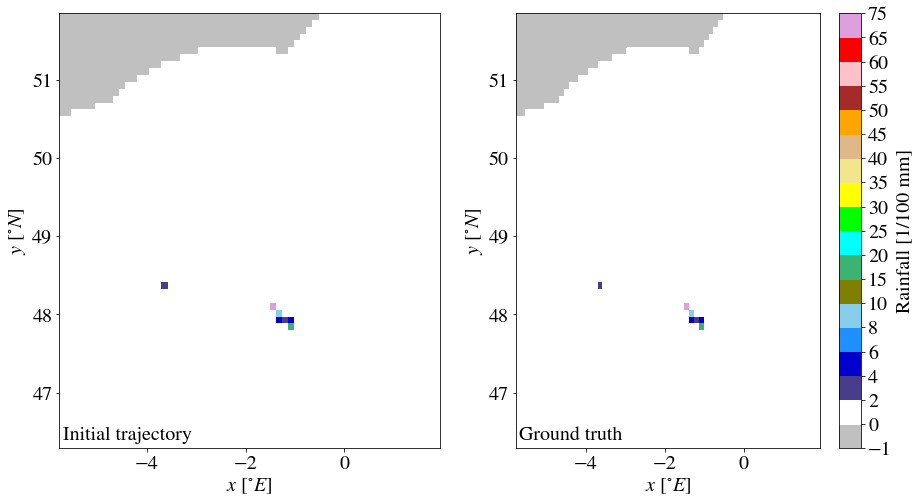

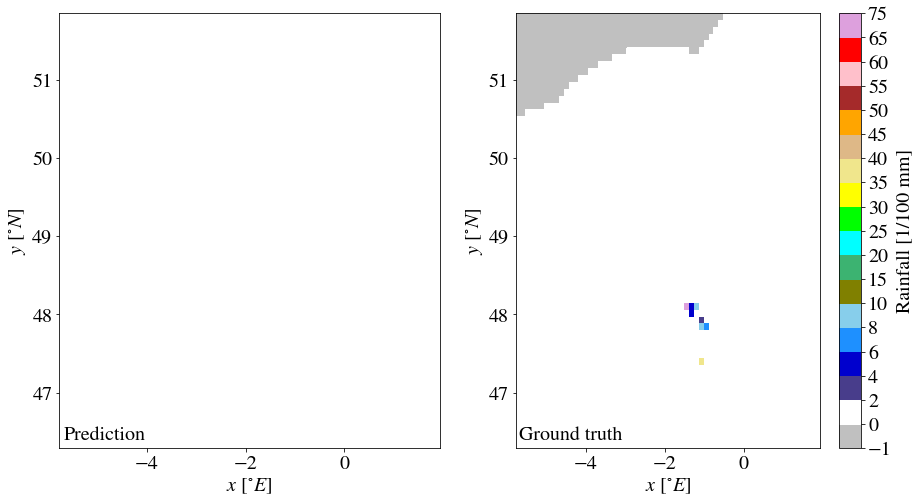

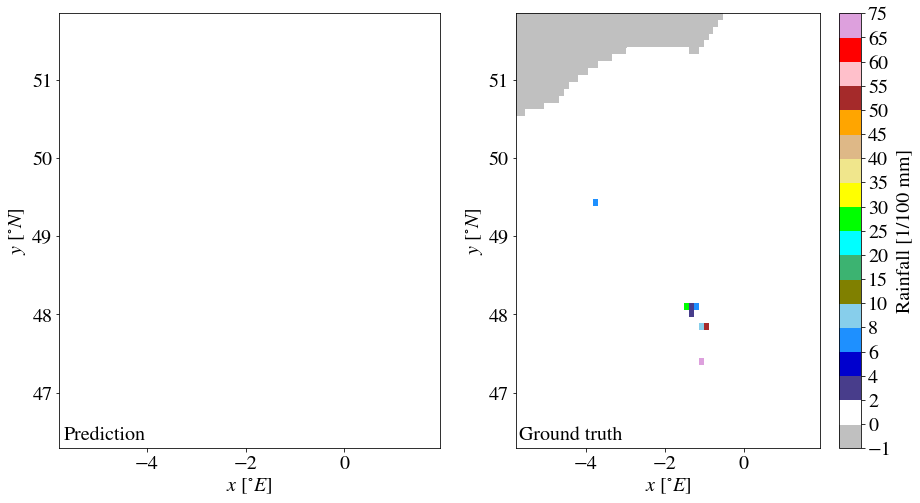

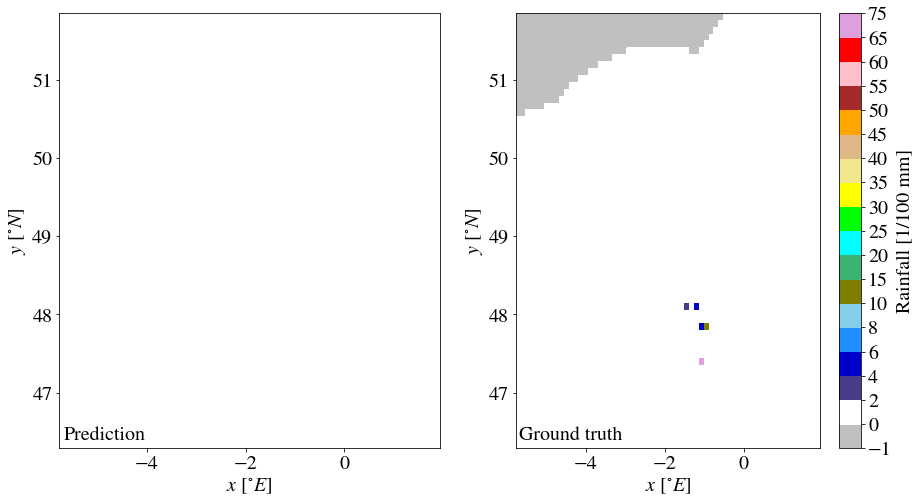

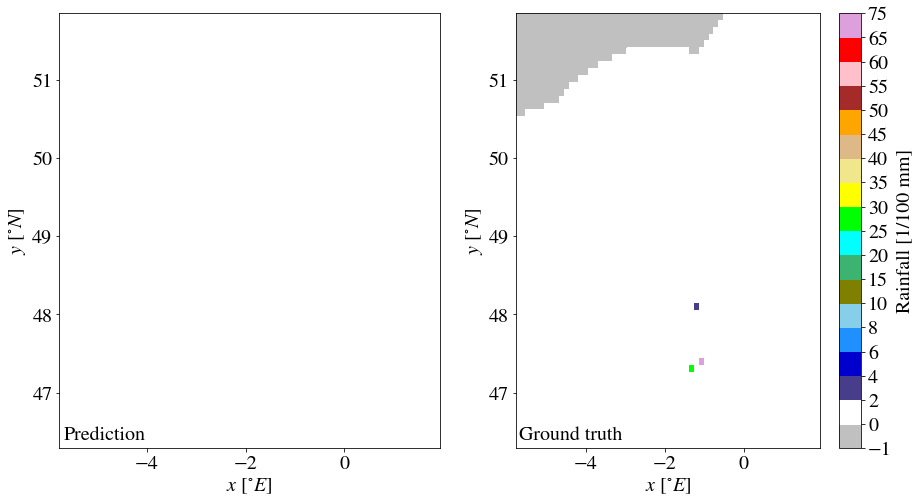

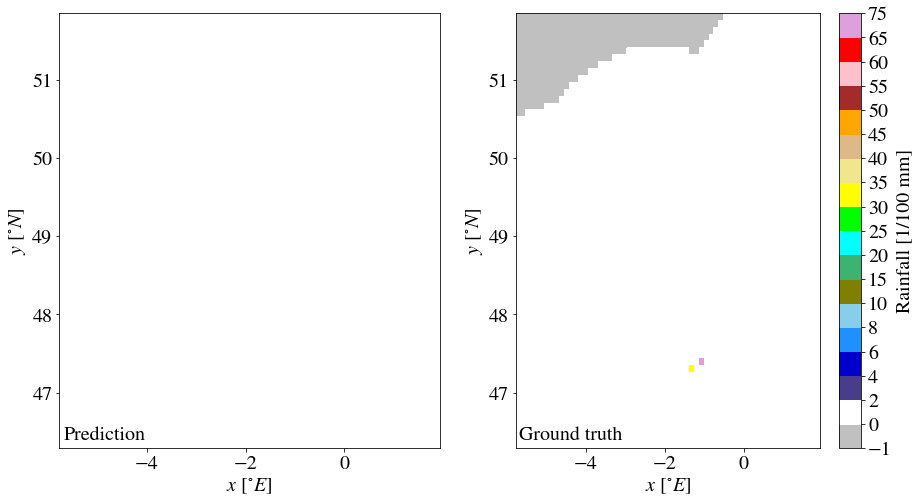

In [16]:
# Plot Train
itest = 3
track = tf.expand_dims(X[itest,:,:,:,0], axis=-1)
true_track = np.concatenate((track, y[itest]), axis=0)
if archi == 'convdlrm':
  track = np.concatenate((track[None,:,:,:,:], model.predict(X[itest][None,:,:,:,:])), axis=1)
elif archi == 'ddnet':
  track_m = X[itest]
  track_c = X_content[itest]
  track = np.concatenate((track[None,:,:,:,:], model.predict([track_m[None,:,:,:,:], track_c[None,:,:,:]])), axis=1)
lat, lon = get_coords(data_dir, zone)
plot_track(true_track, track, rainfall_threshold_value, 
           new_size, input_timeframes, output_timeframes, 
           lat, lon, tag='train', save=True, foldername=foldername)

/home/bdelorme/RainfallNowcasting/Radar/results/ already exists


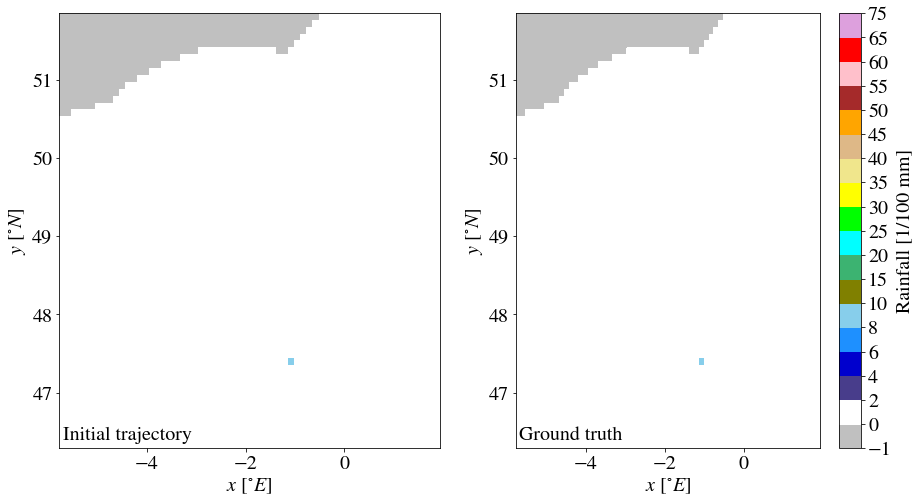

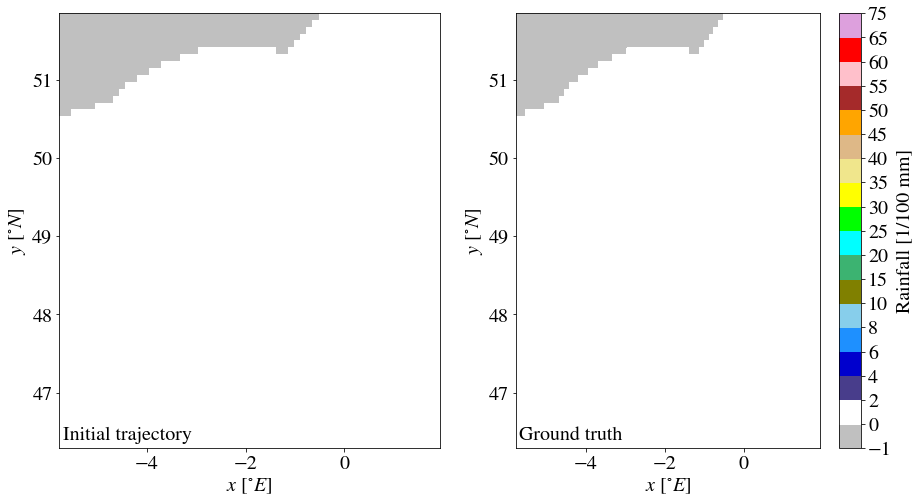

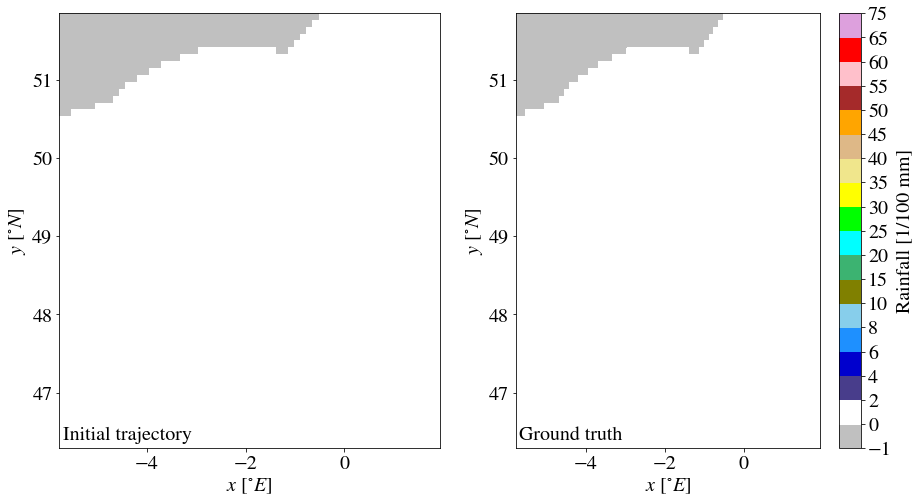

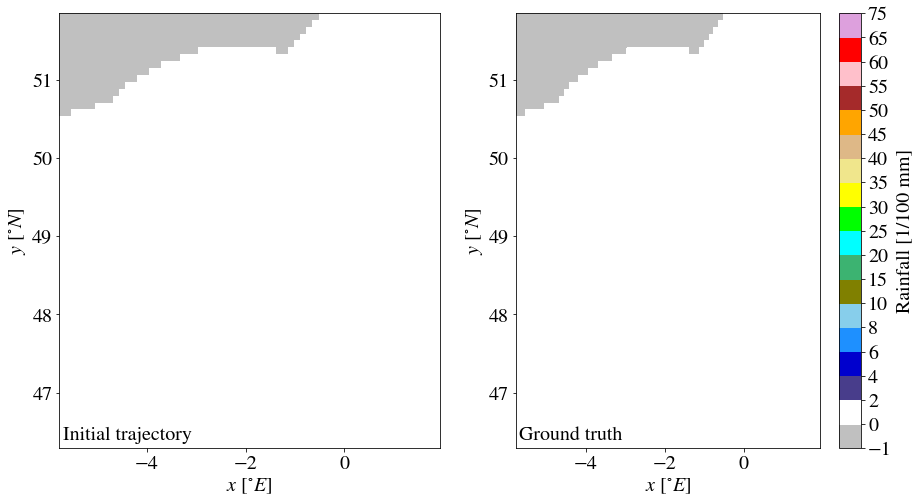

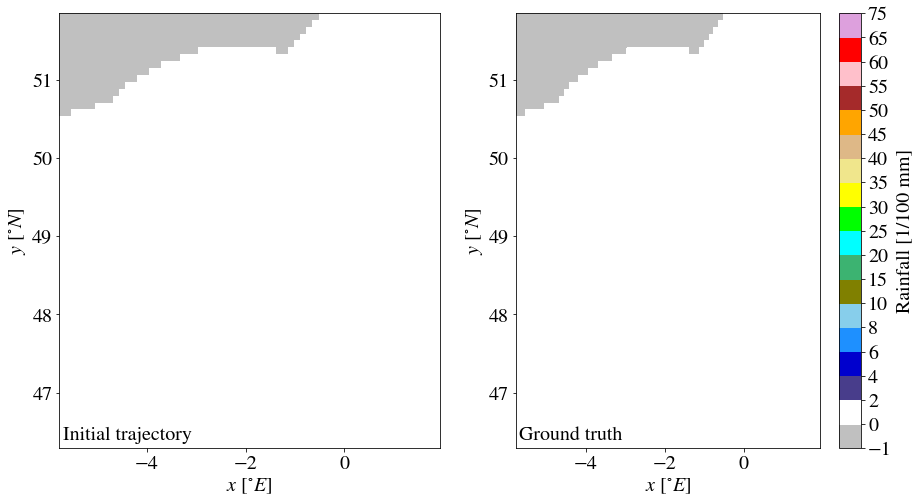

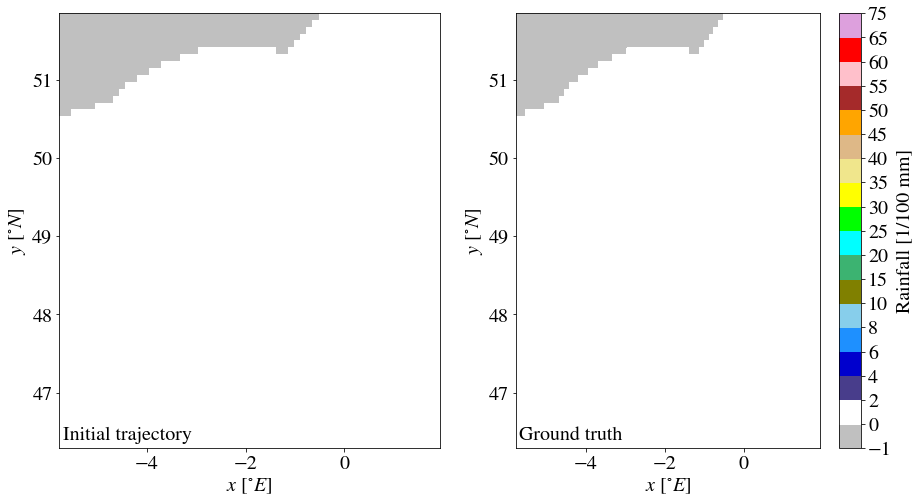

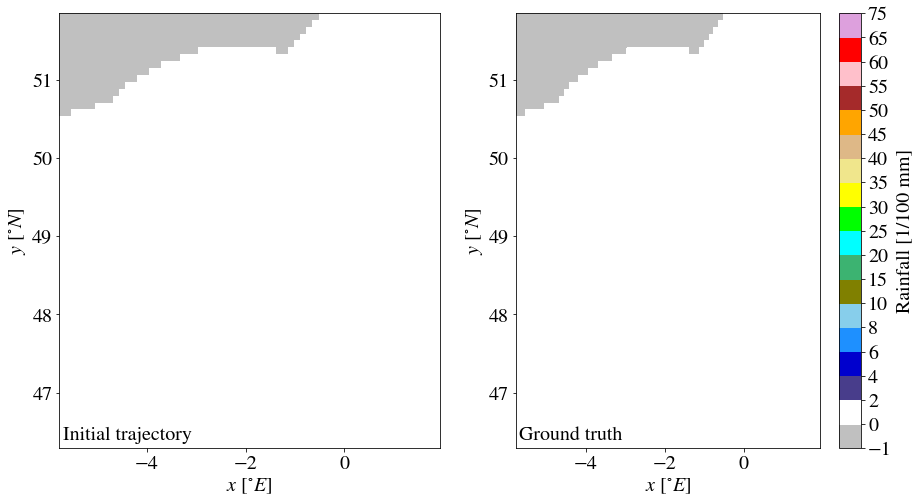

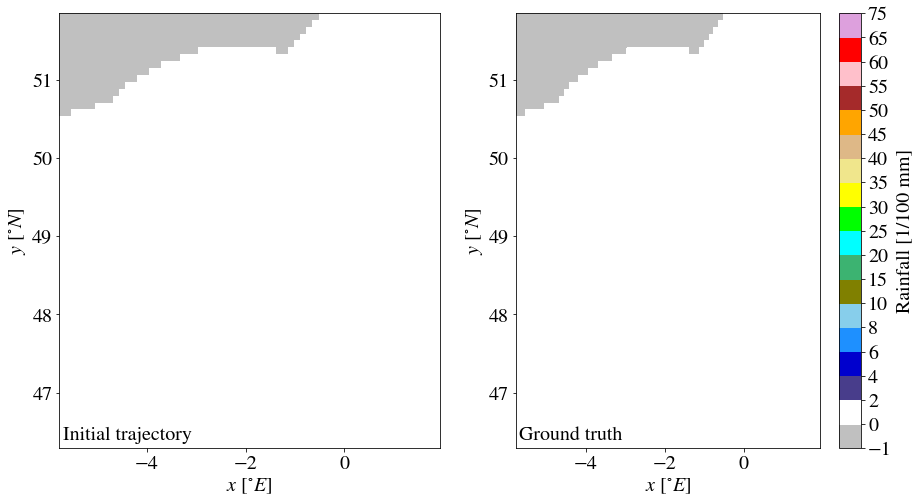

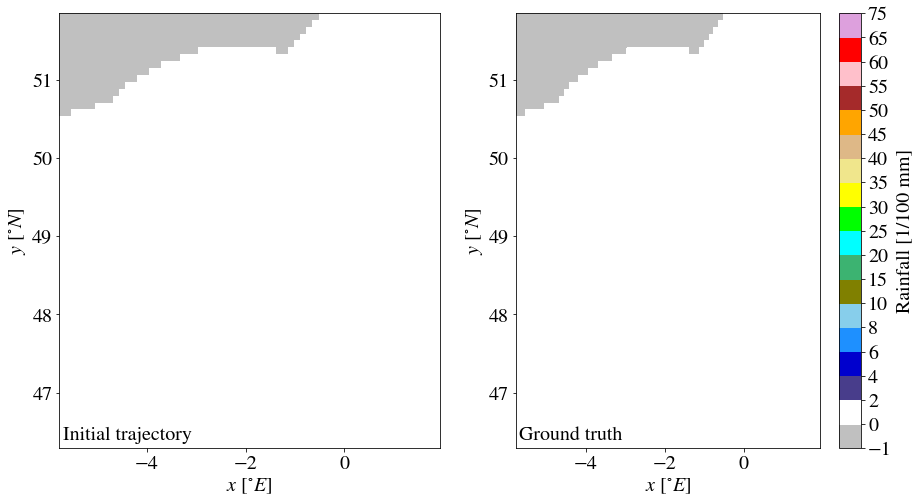

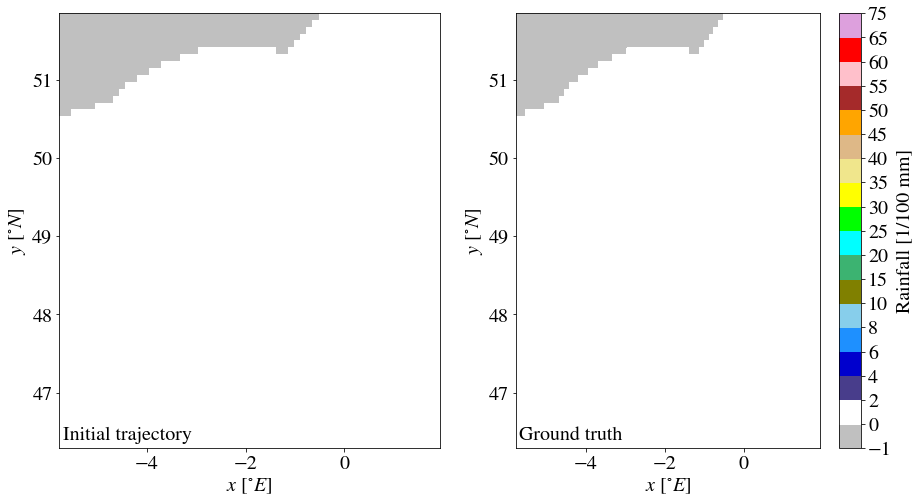

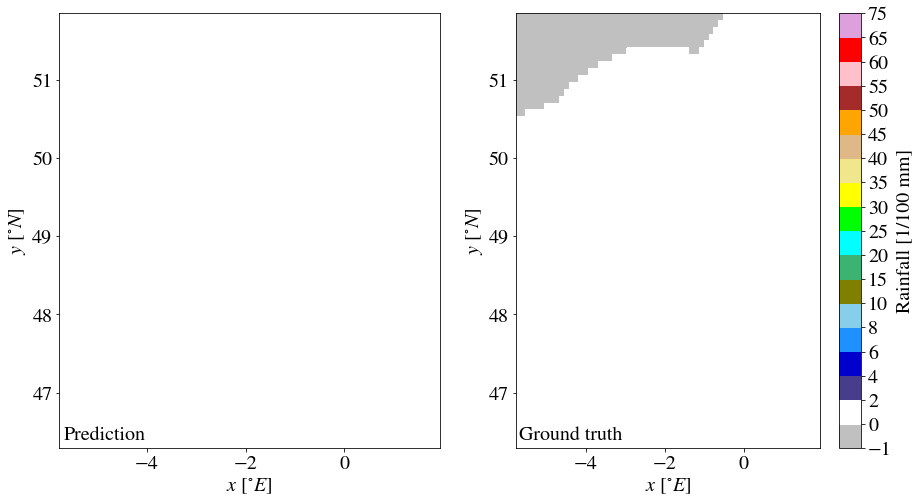

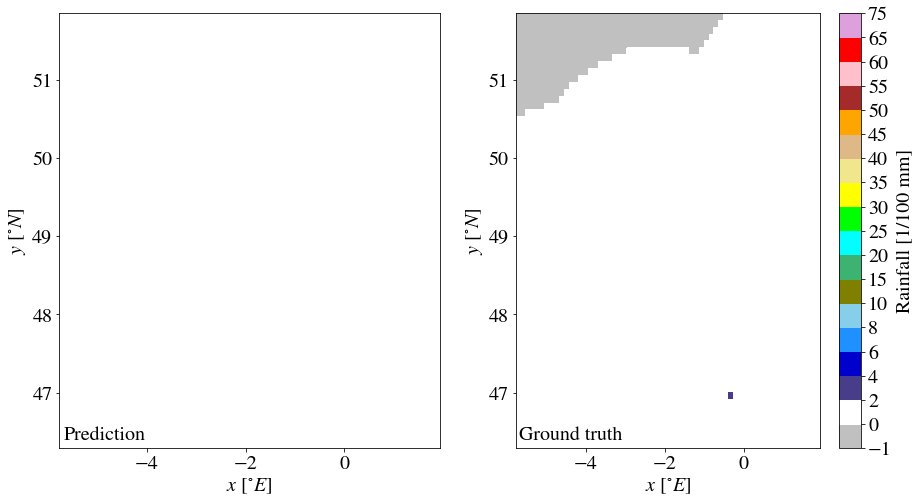

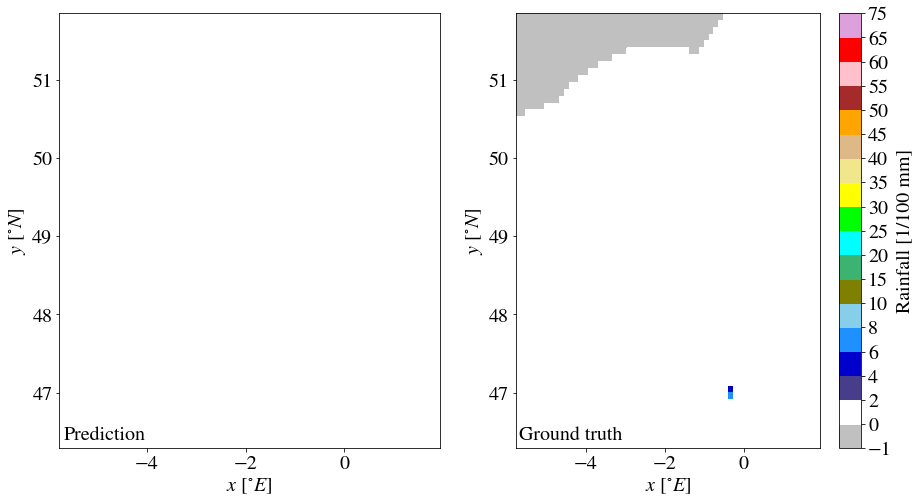

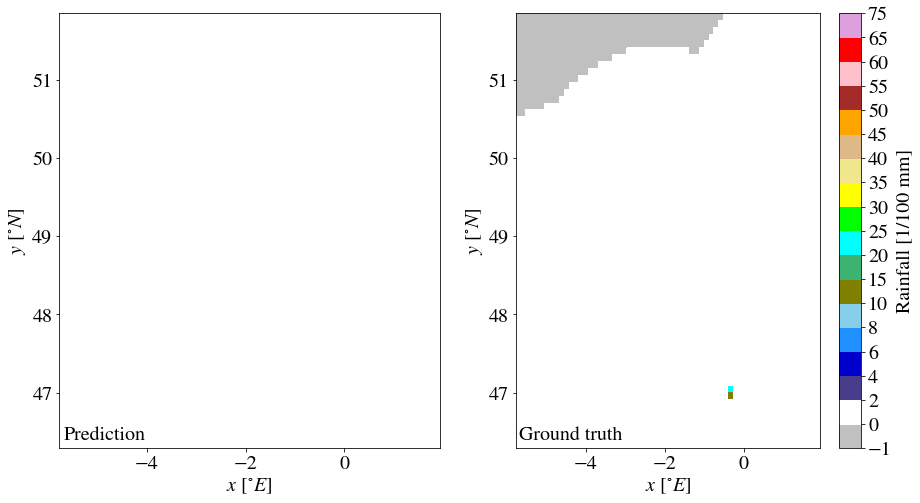

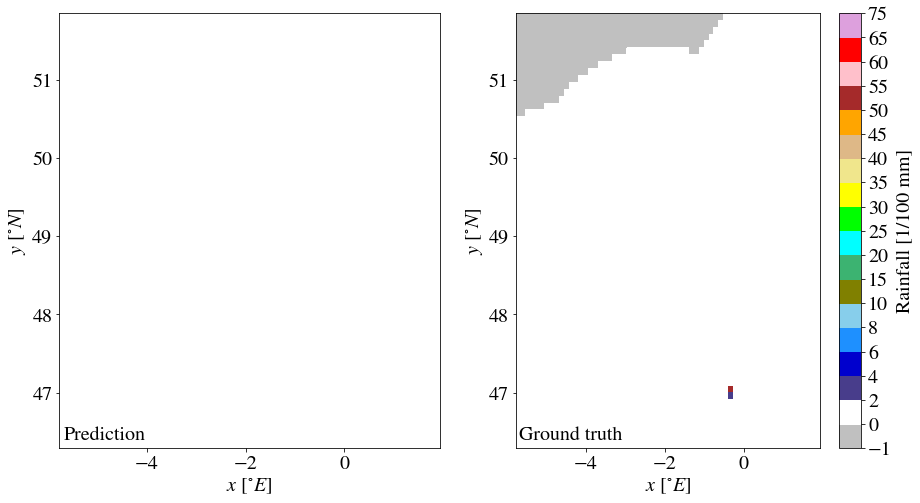

In [17]:
# Plot Test
itest = 3
track = tf.expand_dims(X_test[itest,:,:,:,0], axis=-1)
true_track = np.concatenate((track, y_test[itest]), axis=0)
if archi == 'convdlrm':
  track = np.concatenate((track[None,:,:,:,:], model.predict(X_test[itest][None,:,:,:,:])), axis=1)
elif archi == 'ddnet':
  track_m = X_test[itest]
  track_c = X_content_test[itest]
  track = np.concatenate((track[None,:,:,:,:], model.predict([track_m[None,:,:,:,:], track_c[None,:,:,:]])), axis=1)
lat, lon = get_coords(data_dir, zone)
plot_track(true_track, track, rainfall_threshold_value, 
           new_size, input_timeframes, output_timeframes, 
           lat, lon, tag='train', save=True, foldername=foldername)